In [ ]:
import pandas as pd
import pickle
from collections import Counter

# 입력
data_name = 'XOM'  # BTC, AAPL, BRKb
c_n = 8
alpha = '' # _alpha8, 0.6이면 아무것도 안 넣음
stage = 'train' # train, test
data = pd.read_csv(f'/Data/{data_name}/{data_name}_{stage}.csv')
drop_cols = ['date', 'MA5', 'MA20', 'MA50', 'MA200', 'OT']
data_values = data.drop(columns=[col for col in drop_cols if col in data.columns])

base_path = f'/SIMPC/res/{data_name}/simpc_Framework2_{data_name}_cvr_clus{c_n}_k{c_n}_l18-22_dba_trad'
file_path = f'{base_path}_labels.pkl'
with open(file_path, 'rb') as f:
    labels = pickle.load(f)

file_path = f'{base_path}_centroids.pkl'
with open(file_path, 'rb') as f:
    centroid = pickle.load(f)
    print('centroids shape: ', centroid.shape)
    
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"Label {label}: {count}개")

file_path = f'{base_path}_segmentation.pkl'
with open(file_path, 'rb') as f:
    segmentation = pickle.load(f)
    
file_path = f'{base_path}_subsequences.pkl'
with open(file_path, 'rb') as f:
    subsequence = pickle.load(f)
    print(subsequence[5].shape)



window_size = 20 #--> 나중에 inter한 뒤에 80프로만 쓸 것것
margin = 2  # 패턴과 떨어진 최소 거리

# 1. 패턴에서 사용된 인덱스 집합 만들기
used_indices = set()
for start in segmentation:
    used_indices.update(range(start - margin, start + margin + 1))  # margin 포함

# 2. 가능한 시작 인덱스 후보 생성
max_start = len(data_values) - window_size
candidate_indices = [i for i in range(max_start) if i not in used_indices]

print('노이즈 후보 수: ', len(candidate_indices))
print('전체 시계열에서 패턴의 발생 비율', len(segmentation) / len(data_values))

# 4. noise subsequences 만들기
noise_subsequences = [data_values[i:i+window_size] for i in candidate_indices]
print('noise_subsequence 수: ', len(noise_subsequences)) #(45, 22, 3)
print('noise_subsequence.shape[1]: ', len(noise_subsequences[0])) #(x, 22, 3)

centroids shape:  (8, 22, 3)
Label 0: 83개
Label 1: 77개
Label 2: 84개
Label 3: 134개
Label 4: 90개
Label 5: 61개
Label 6: 69개
Label 7: 44개
(22, 3)
노이즈 후보 수:  180
전체 시계열에서 패턴의 발생 비율 0.18849089841456254
noise_subsequence 수:  180
noise_subsequence.shape[1]:  20


In [561]:
# 1. subsequence와 noise_subsequences 합치기
subsequence_list = list(subsequence)
noise_array_list = [df.values for df in noise_subsequences]
all_subsequences = subsequence_list  + noise_array_list #array

# 2. segmentation과 candidate_indices 합치기
all_indices = list(int(i) for i in segmentation) + list(candidate_indices) #list

# 3. labels와 -1로 채운 리스트 합치기
all_labels = list(labels) + [-1] * len(candidate_indices)

# 결과 확인
print(f"전체 subsequence 수: {len(all_subsequences)}")        # pattern + noise
print(f"전체 index 수: {len(all_indices)}")                  # subsequence의 시작 위치
print(f"전체 label 수: {len(all_labels)}")                  # subsequence의 label (-1은 noise)

# 일관성 확인
assert len(all_subsequences) == len(all_indices) == len(all_labels), "길이가 일치하지 않음!"

전체 subsequence 수: 822
전체 index 수: 822
전체 label 수: 822


In [562]:
#보간 및 0-1 정규화 작업

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d


def interpolate_normalize_subsequences(subsequences, target_length=100):
    """
    모든 인스턴스(68개)와 변수(3개)에 대해 시계열을 target_length(100)으로 선형 보간.

    :param subsequences: (68, 3, x) 형태의 리스트 (x는 가변 길이)
    :param target_length: 보간 후 목표 길이 (기본값 100)
    :return: (68, 3, 100) 형태의 numpy 배열
    """
    num_instances = len(subsequences)  # 인스턴스 수 (68)
    print('num_instances', num_instances)
    num_variables = len(subsequences[0])  # 변수 수 (3)
    print('num_variables',num_variables)

    # 보간 후 저장할 배열
    interpolated_data = np.zeros((num_instances, num_variables, target_length))

    for i in range(num_instances):  # 각 인스턴스 반복
        for j in range(num_variables):  # 각 변수 반복
            series = np.array(subsequences[i][j])  # 현재 시계열 데이터 (x 길이)

            # 기존 x 좌표 설정
            original_length = len(series)
            x_old = np.linspace(0, 1, original_length)  # 기존 데이터의 x 좌표
            x_new = np.linspace(0, 1, target_length)  # 새로운 길이의 x 좌표

            # 선형 보간 함수 적용
            interpolator = interp1d(x_old, series, kind='cubic')
            interpolated_series = interpolator(x_new)

            # 정규화 (Min-Max Scaling)
            min_val = np.min(interpolated_series)
            max_val = np.max(interpolated_series)
            if max_val - min_val == 0:
                normalized_series = np.zeros_like(interpolated_series)  # 값이 모두 같으면 0으로 채움
            else:
                normalized_series = (interpolated_series - min_val) / (max_val - min_val)

            interpolated_data[i, j] = normalized_series
    return interpolated_data


target_length = 100  # 선형보간작업 얼마나 할건지 
subsequences_list = [arr.T for arr in subsequence]
print(subsequences_list[0].shape)
print(len(subsequences_list))
subsequence_inter = interpolate_normalize_subsequences(subsequences_list, target_length)
print("not noise Data Shape:", subsequence_inter.shape)  # (499, 3, 100)

noise_list = np.stack([df.values.T for df in noise_subsequences])  # Transpose to (3, 22)
noise_inter = interpolate_normalize_subsequences(noise_list, target_length)
print("nosie Data Shape:", noise_inter.shape)  # (45, 3, 100)

all_list = [arr.T for arr in all_subsequences]  # shape: (3, x)
all_inter = interpolate_normalize_subsequences(all_list, target_length)
cutoff = int(all_inter.shape[2] * 0.8)  # 100 * 0.8 = 80
all_inter = all_inter[:, :, :cutoff]
print("all_inter Data Shape:", all_inter.shape)  # (45, 3, 100)

(3, 20)
642
num_instances 642
num_variables 3
not noise Data Shape: (642, 3, 100)
num_instances 180
num_variables 3
nosie Data Shape: (180, 3, 100)
num_instances 822
num_variables 3


all_inter Data Shape: (822, 3, 80)


In [ ]:
%cd /JISC-Net/jiscnet
!nvidia-smi

In [564]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import wrappers
import warnings
import json
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
prefix_file = f'/JISC-Net/jiscnet/result/F_{data_name}_{c_n}_shapelet{c_n + 2}{alpha}'


file_path = f'{prefix_file}_shapelet.pkl'
with open(file_path, 'rb') as f:
    shapelet = pickle.load(f)
    
file_path = f'{prefix_file}_utility_sort_index.pkl'
with open(file_path, 'rb') as f:
    utility_sort_index = pickle.load(f)

model = wrappers.CausalCNNEncoderClassifier()
hf = open('/JISC-Net/jiscnet/default_parameters.json', 'r')
hp_dict = json.load(hf)
hf.close()
model.set_params(**hp_dict)
model.load(prefix_file)

encoder = model.encoder
encoder.eval()
print(next(encoder.parameters()).device)

classifier = model.classifier

X_train_features = model.shapelet_transformation(all_inter, shapelet, utility_sort_index)
print("X_train_features shape: ", X_train_features.shape)
train_probs = classifier.predict_proba(X_train_features)
print('train_probs: ', train_probs.shape)

In [ ]:
train_max_probs = np.max(train_probs, axis=1)
print('train_max_probs: ', train_max_probs.shape)

true_labels = np.array(all_labels)
pred_labels = np.argmax(train_probs, axis=1) # 예측 label

print('true_labels: ', true_labels.shape)
print('pred_labels: ', pred_labels.shape)

train_max_probs:  (822,)
true_labels:  (822,)
pred_labels:  (822,)


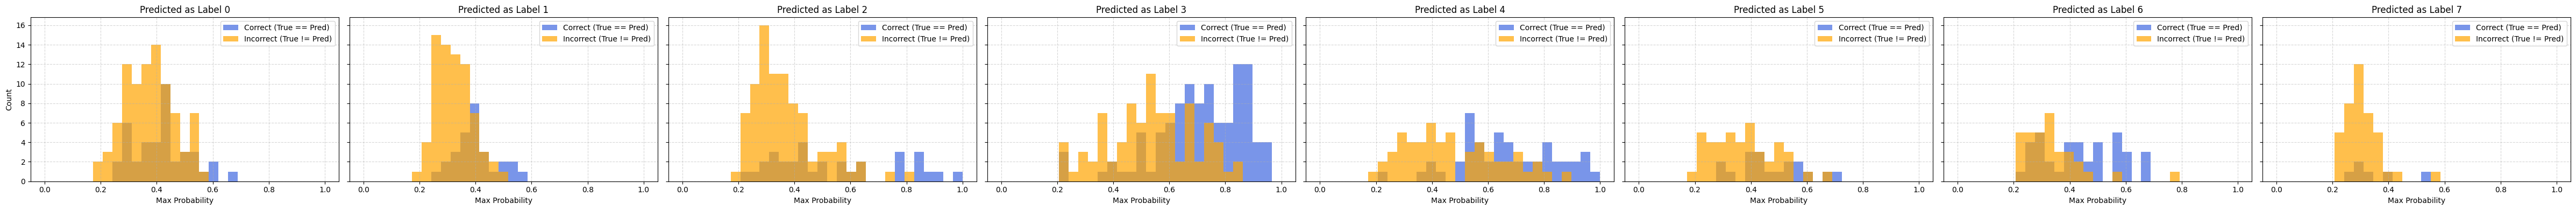

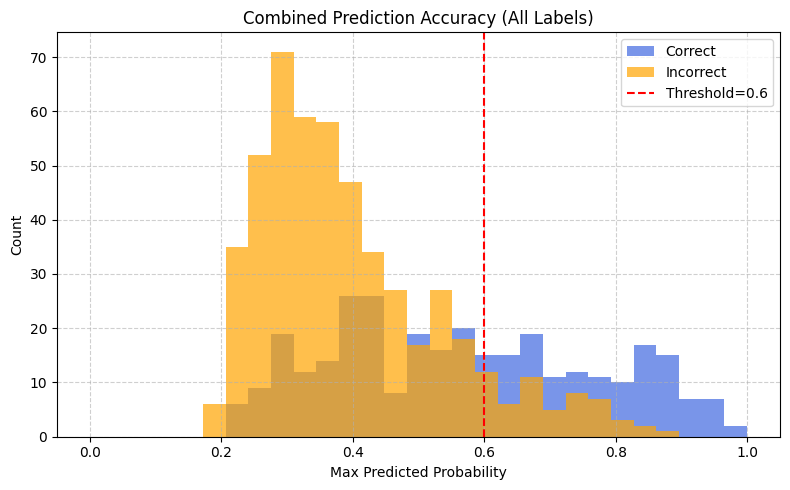

In [567]:
correct_mask = pred_labels == true_labels
max_probs = train_max_probs

unique_labels = np.unique([label for label in true_labels if label != -1])
bins = np.linspace(0, 1.0, 30)

# 각 라벨별 개별 히스토그램
fig, axes = plt.subplots(1, len(unique_labels), figsize=(6 * len(unique_labels), 4), sharey=True)

# 통합용 배열 초기화
all_correct = []
all_incorrect = []

for idx, label in enumerate(unique_labels):
    ax = axes[idx] if len(unique_labels) > 1 else axes

    # 이 라벨로 예측한 경우
    label_pred_mask = (pred_labels == label)

    # 그 중 실제 정답인 경우 / 아닌 경우
    correct = max_probs[label_pred_mask & (true_labels == label)]
    incorrect = max_probs[label_pred_mask & (true_labels != label)]

    all_correct.extend(correct)
    all_incorrect.extend(incorrect)

    # 히스토그램 그리기
    ax.hist(correct, bins=bins, alpha=0.7, label='Correct (True == Pred)', color='royalblue')
    ax.hist(incorrect, bins=bins, alpha=0.7, label='Incorrect (True != Pred)', color='orange')
    ax.set_title(f"Predicted as Label {label}")
    ax.set_xlabel("Max Probability")
    if idx == 0:
        ax.set_ylabel("Count")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 전체 Correct vs Incorrect 히스토그램
plt.figure(figsize=(8, 5))
plt.hist(all_correct, bins=bins, alpha=0.7, label="Correct", color='royalblue')
plt.hist(all_incorrect, bins=bins, alpha=0.7, label="Incorrect", color='orange')
plt.axvline(x=0.6, color='red', linestyle='--', label="Threshold=0.6")
plt.xlabel("Max Predicted Probability")
plt.ylabel("Count")
plt.title("Combined Prediction Accuracy (All Labels)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [568]:
from scipy.stats import ks_2samp
from sklearn.metrics import precision_score
import numpy as np

# 1. KS-test로 유의미하지 않은 라벨 추출
significant_labels = []

for label in unique_labels:
    label_pred_mask = (pred_labels == label)
    correct = max_probs[label_pred_mask & (true_labels == label)]
    incorrect = max_probs[label_pred_mask & (true_labels != label)]

    if len(correct) > 0 and len(incorrect) > 0:
        ks_stat, ks_p = ks_2samp(correct, incorrect)
        print(f"[Label {label}] KS test → stat={ks_stat:.3f}, p={ks_p:.4e}")
        if ks_p < 0.05:
            significant_labels.append(label)
    else:
        print(f"[Label {label}] 데이터 부족으로 테스트 생략")

insignificant_labels = set(unique_labels) - set(significant_labels)
print("\n✅ 유의미하지 않은 라벨들:", insignificant_labels)

# 2. KS 기반 필터 적용: 라벨이 유의미하지 않으면 -1로
ks_filtered_preds = np.array([
    label if label not in insignificant_labels else -1
    for label in pred_labels
])

[Label 0] KS test → stat=0.282, p=1.9769e-02
[Label 1] KS test → stat=0.476, p=1.1068e-04
[Label 2] KS test → stat=0.409, p=4.9145e-04
[Label 3] KS test → stat=0.478, p=2.1593e-10
[Label 4] KS test → stat=0.505, p=1.3185e-06
[Label 5] KS test → stat=0.415, p=1.7616e-02
[Label 6] KS test → stat=0.427, p=1.9305e-03
[Label 7] KS test → stat=0.283, p=7.0517e-01

✅ 유의미하지 않은 라벨들: {np.int64(7)}


In [ ]:
from sklearn.metrics import precision_score

# 3. Precision 기준 threshold 탐색 (KS 필터 적용된 상태에서만)
thresholds = np.linspace(0.1, 0.9, 81)
min_coverage = 0.2  # 최소 20%는 예측해야 한다
best_threshold = 0.0
best_precision = 0.0

for T in thresholds:
    pred_T = np.where(train_max_probs >= T, pred_labels, -1)
    valid_mask = pred_T != -1
    preds = pred_T[valid_mask]
    trues = true_labels[valid_mask]
    coverage = np.mean(valid_mask)

    if coverage >= min_coverage and len(preds) > 0:
        precision = precision_score(trues, preds, average='micro')
        if precision > best_precision:
            best_precision = precision
            best_threshold = T

print(f"\n✅ 최적 threshold (KS 필터 후): {best_threshold:.2f}, Precision: {best_precision:.4f}")

# 4. 최종 예측: KS 필터 + threshold 필터 모두 적용
final_preds = np.where(train_max_probs >= best_threshold, ks_filtered_preds, -1)

# 5. Noise로 분류된 수 비교
total_samples = len(pred_labels)
ks_noise_count = np.sum(ks_filtered_preds == -1)
final_noise_count = np.sum(final_preds == -1)

print(f"\n📊 전체 샘플 수: {total_samples}")
print(f"🔹 KS 필터로 noise 처리된 수: {ks_noise_count} ({ks_noise_count/total_samples:.2%})")
print(f"🔸 최종 noise 수 (KS + Threshold): {final_noise_count} ({final_noise_count/total_samples:.2%})")



✅ 최적 threshold (KS 필터 후): 0.62, Precision: 0.7456

📊 전체 샘플 수: 822
🔹 KS 필터로 noise 처리된 수: 46 (5.60%)
🔸 최종 noise 수 (KS + Threshold): 653 (79.44%)


In [ ]:
!pip install seaborn

✅ Confusion Matrix BEFORE Threshold:
         Pred -1  Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5  Pred 6  \
True -1        0      17      38      42      18      19      21       6   
True 0         0      40      10      14       1       7       3       7   
True 1         0      25      28      14       0       1       3       4   
True 2         0      10       1      32      14      16      10       1   
True 3         0       0       1       1     105      10       4       2   
True 4         0       0       0       0      39      49       2       0   
True 5         0       5       7       3      14       3      18       6   
True 6         0      14       8       7       0       0       0      38   
True 7         0      16       7       7       1       0       0       7   

         Pred 7  
True -1      19  
True 0        1  
True 1        2  
True 2        0  
True 3       11  
True 4        0  
True 5        5  
True 6        2  
True 7        6  

✅ Confusion Matrix AF

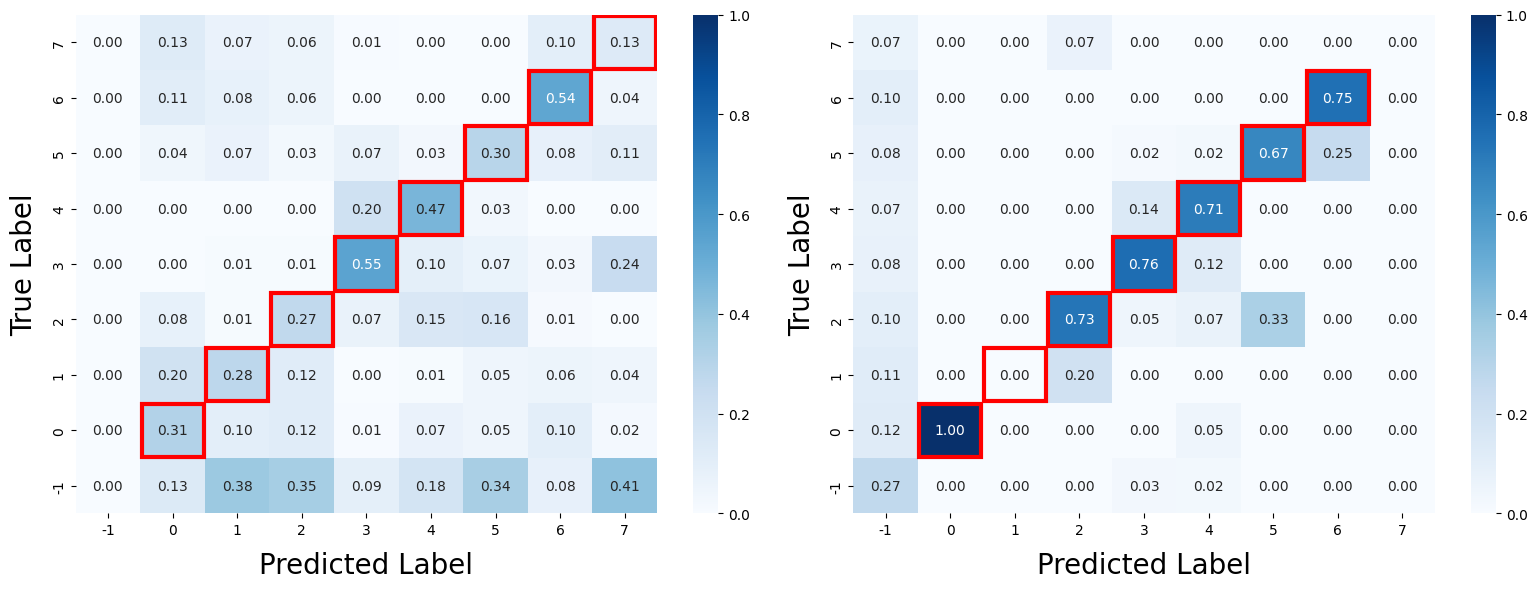

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.patches as patches

# 원래 예측값
original_preds = pred_labels

# threshold 적용된 예측값
thresholded_preds = final_preds  # 이미 np.where(...)로 구해진 상태

# 모든 라벨 정리 (noise -1 포함)
label_set = sorted(set(np.unique(true_labels)) | set(np.unique(thresholded_preds)))
axis_set = sorted([-1] + [int(i) for i in unique_labels])

# 혼동 행렬 계산
cm_before = confusion_matrix(true_labels, original_preds, labels=axis_set)
cm_after = confusion_matrix(true_labels, thresholded_preds, labels=axis_set)

# 보기 좋게 출력
df_before = pd.DataFrame(cm_before, index=[f"True {l}" for l in axis_set],
                                     columns=[f"Pred {l}" for l in axis_set])
df_after = pd.DataFrame(cm_after, index=[f"True {l}" for l in axis_set],
                                   columns=[f"Pred {l}" for l in axis_set])

print("✅ Confusion Matrix BEFORE Threshold:")
print(df_before)

print("\n✅ Confusion Matrix AFTER Threshold:")
print(df_after)


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

def plot_dual_confusion_heatmap_colnorm_filtered_with_diagonal(
    cm_before, cm_after,
    labels, pred_label_range,
    excluded_preds_right,
    excluded_preds_left={-1},
    unique_labels=None,
    titles=("Before Threshold", "After Threshold")
):
    import matplotlib.patches as patches

    # 열 기준 정규화
    cm_before_norm = cm_before.astype('float')
    cm_after_norm = cm_after.astype('float')

    cm_before_norm = np.divide(cm_before_norm, cm_before_norm.sum(axis=0, keepdims=True),
                                out=np.zeros_like(cm_before_norm), where=cm_before_norm.sum(axis=0, keepdims=True)!=0)
    cm_after_norm = np.divide(cm_after_norm, cm_after_norm.sum(axis=0, keepdims=True),
                               out=np.zeros_like(cm_after_norm), where=cm_after_norm.sum(axis=0, keepdims=True)!=0)

    # 열 필터링: 예측값이 0~5인 열만 보기
    pred_indices = [labels.index(l) for l in pred_label_range if l in labels]
    filtered_labels = [labels[i] for i in pred_indices]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 가로 길이 증가
    plt.subplots_adjust(wspace=0.2)  # 🔧 두 그래프 간 간격 줄임 (기본은 0.4~0.5)


    for idx, (ax, cm_norm, title) in enumerate(zip(axes, [cm_before_norm, cm_after_norm], titles)):
        cm_filtered = cm_norm[:, pred_indices]

        sns.heatmap(
            cm_filtered,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=filtered_labels,
            yticklabels=labels,
            vmin=0.0,
            vmax=1.0,
            ax=ax
        )
        ax.set_xlabel("Predicted Label", fontsize=20, labelpad=10)
        ax.set_ylabel("True Label", fontsize=20, labelpad=10)
        ax.tick_params(axis='both', labelsize=10)
        ax.invert_yaxis()


        offset = 0.02  # or 0.03 for 더 안쪽

        for row_idx, true_label in enumerate(labels):
            for col_idx, pred_label in zip(range(len(filtered_labels)), filtered_labels):
                if true_label == pred_label:

                    # 🔒 오른쪽 heatmap에서는 unique_labels만 허용
                    if idx == 1 and true_label not in unique_labels:
                        continue

                    # 🔒 제외된 라벨 무시
                    if idx == 1 and pred_label in excluded_preds_right:
                        continue
                    if idx == 0 and pred_label in excluded_preds_left:
                        continue

                    # ✅ 빨간 박스 그리기
                    rect = patches.Rectangle(
                        (col_idx + offset, row_idx + offset),
                        1 - 2 * offset,
                        1 - 2 * offset,
                        fill=False, edgecolor='red', linewidth=3
                    )
                    ax.add_patch(rect)
                    

    plt.tight_layout()
    plt.show()


insignificant_list = [int(i) for i in insignificant_labels] + [-1]
plot_dual_confusion_heatmap_colnorm_filtered_with_diagonal(
    cm_before, cm_after,
    labels=axis_set,
    pred_label_range=axis_set,
    excluded_preds_right=insignificant_list,
    excluded_preds_left={-1},
    unique_labels=unique_labels  # ✅ 꼭 전달
)

# For test data

## label 별 방향성 구하기

In [ ]:
c_n = 8
base_path = f'/SIMPC/res/{data_name}/simpc_Framework2_{data_name}_cvr_clus{c_n}_k{c_n}_l18-22_dba_trad'
file_path = f'{base_path}_labels.pkl'
with open(file_path, 'rb') as f:
    labels = pickle.load(f)

label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"Label {label}: {count}개")

file_path = f'{base_path}_segmentation.pkl'
with open(file_path, 'rb') as f:
    segmentation = pickle.load(f)
    
file_path = f'{base_path}_subsequences.pkl'
with open(file_path, 'rb') as f:
    subsequence = pickle.load(f)
    print(subsequence[0].shape)

Label 0: 83개
Label 1: 77개
Label 2: 84개
Label 3: 134개
Label 4: 90개
Label 5: 61개
Label 6: 69개
Label 7: 44개
(20, 3)


In [ ]:

import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.interpolate import interp1d


# 결과 저장
returns_by_label = defaultdict(list)
directions_by_label = defaultdict(list)

train_data = pd.read_csv(f'/Data/{data_name}/{data_name}_train.csv')

# test_data는 전체 시계열 (DataFrame), "close" 컬럼이 있어야 함
close_series = train_data["close"].values

for i in range(len(subsequence)):
    label = labels[i]
    start_idx = segmentation[i]
    subseq_len = subsequence[i].shape[0]  # subsequence 길이 (원래 시계열 기준)

    # subsequence에 해당하는 원본 close 시계열 조각 추출
    raw_close = close_series[start_idx : start_idx + subseq_len]

    # 보간: 길이를 100으로 맞춤
    x_old = np.linspace(0, 1, len(raw_close))
    x_new = np.linspace(0, 1, 100)
    interpolator = interp1d(x_old, raw_close, kind='linear')
    interpolated_close = interpolator(x_new)

    # 4/5 = 80번째, 5/5 = 99번째
    price_start = interpolated_close[80]
    price_end = interpolated_close[99]

    # 수익률 계산
    if price_start == 0:
        continue  # 0으로 나누는 것 방지
    return_ratio = (price_end - price_start) / price_start
    direction = np.sign(price_end - price_start)  # +1, 0, -1

    # 레이블별 저장
    returns_by_label[label].append(return_ratio)
    directions_by_label[label].append(direction)

# 평균 계산
for label in sorted(set(labels)):
    ret_list = returns_by_label[label]
    dir_list = directions_by_label[label]
    
    if ret_list:
        mean_return = np.mean(ret_list)
        mean_direction = np.mean(dir_list)
        print(f"Label {label}: 평균 수익률 = {mean_return:.4f}, 평균 방향성 = {mean_direction:.2f}")
    else:
        print(f"Label {label}: 데이터 없음")
        #0, 1, 4

Label 0: 평균 수익률 = 0.0176, 평균 방향성 = 0.61
Label 1: 평균 수익률 = 0.0106, 평균 방향성 = 0.27
Label 2: 평균 수익률 = 0.0128, 평균 방향성 = 0.57
Label 3: 평균 수익률 = -0.0299, 평균 방향성 = -0.64
Label 4: 평균 수익률 = 0.0022, 평균 방향성 = 0.04
Label 5: 평균 수익률 = -0.0081, 평균 방향성 = -0.48
Label 6: 평균 수익률 = 0.0012, 평균 방향성 = 0.16
Label 7: 평균 수익률 = -0.0055, 평균 방향성 = -0.36


In [575]:
# 평균 계산 및 출력 + 매핑
label_mapping = {-1: -1}  # -1은 기본 고정
print("\n[라벨별 평균 수익률 및 방향성]")
for label in sorted(set(labels)):
    ret_list = returns_by_label[label]
    dir_list = directions_by_label[label]
    
    if ret_list:
        mean_return = np.mean(ret_list)
        mean_direction = np.mean(dir_list)

        if mean_direction > 0:
            label_mapping[label] = 1  # 롱
        elif mean_direction < 0:
            label_mapping[label] = 0  # 숏
        else:
            label_mapping[label] = -1  # 거래 안함
    else:
        print(f"Label {label}: 데이터 없음")
        label_mapping[label] = -1  # 데이터 없을 땐 거래 안함 처리

print("\n[자동 생성된 Label 매핑]")
print(label_mapping)


[라벨별 평균 수익률 및 방향성]

[자동 생성된 Label 매핑]
{-1: -1, 0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0}


In [ ]:
stage = 'test' # train, test
data = pd.read_csv(f'/Data/{data_name}/{data_name}_{stage}.csv')
drop_cols = ['date', 'MA5', 'MA20', 'MA50', 'MA200']
df = data.drop(columns=[col for col in drop_cols if col in data.columns])

series_length = 20
columns = ["close", "v", "RSI" "OT"]
price_now = [] #현재 패턴이 x일 때 이때의 제일 마지막 가격
price_future = [] #현재 패턴이 x일 때 이때의 제일 마지막 일 + 4일의 가격

for i in range(15, len(df) - 4+1, 4):
    price_now.append(df["close"][i])
    price_future.append(df["close"][i+4])


data_rows = []
labels = []

for i in range(0, len(df) - series_length+1, 4):
    close_series = df["close"][i : i + series_length].tolist()
    volume_series = df["v"][i : i + series_length].tolist()
    rsi_series = df["RSI"][i : i + series_length].tolist()

    # (3, series_length) 형태로 만들기
    sample = np.array([close_series, volume_series, rsi_series])  # shape: (3, series_length)
    data_rows.append(sample)

    # 레이블 저장
    label = df["OT"][i + series_length-5]
    labels.append(label)

# 리스트를 최종 numpy array로 변환
data_array = np.stack(data_rows)  # shape: (N, 3, series_length)
labels_array = np.array(labels)   # shape: (N,)

# 확인
print("data_array.shape:", data_array.shape)
print("labels_array.shape:", labels_array.shape)

In [577]:
target_length = 80 #학습단계와 동일하게 맞춤
test_inter = interpolate_normalize_subsequences(data_array, target_length)
test_inter.shape

num_instances 233
num_variables 3


(233, 3, 80)

In [ ]:
prefix_file = f'/JISC-Net/jiscnet/result/F_{data_name}_{c_n}_shapelet{c_n + 2}{alpha}'

file_path = f'{prefix_file}_shapelet.pkl'
with open(file_path, 'rb') as f:
    shapelet = pickle.load(f)
    
file_path = f'{prefix_file}_utility_sort_index.pkl'
with open(file_path, 'rb') as f:
    utility_sort_index = pickle.load(f)

model = wrappers.CausalCNNEncoderClassifier()
hf = open('/JISC-Net/jiscnet/default_parameters.json', 'r')
hp_dict = json.load(hf)
hf.close()
model.set_params(**hp_dict)
model.load(prefix_file)

encoder = model.encoder
encoder.eval()
print(next(encoder.parameters()).device)

classifier = model.classifier

X_test_features = model.shapelet_transformation(test_inter, shapelet, utility_sort_index)
print("X_test_features shape: ", X_test_features.shape)
test_probs = classifier.predict_proba(X_test_features)
print('test_probs: ', test_probs.shape)

In [579]:
test_max_probs = np.max(test_probs, axis=1)
#print('pattern_max_probs: ', pattern_max_probs)
print('test_max_probs: ', test_max_probs.shape)

true_labels = labels_array
pred_labels = np.argmax(test_probs, axis=1) # 예측 label
true_labels = labels_array
pred_labels_ori = pred_labels
print('true_labels: ', true_labels.shape)
print('pred_labels: ', pred_labels.shape)

test_max_probs:  (233,)
true_labels:  (233,)
pred_labels:  (233,)


In [ ]:
allowed_labels = [int(x) for x in significant_labels]

In [ ]:
# 최종 threshold 적용 결과
# 허용된 클래스 목록
#allowed_labels = {0, 1, 4}

# 0,1,4 외에는 -1로 대체
ks_filtered_preds = np.where(np.isin(pred_labels, list(allowed_labels)), pred_labels, -1)
final_preds = np.where(test_max_probs >= best_threshold, ks_filtered_preds, -1)
valid_mask = final_preds != -1

# 비율 계산
valid_ratio = np.mean(valid_mask)
valid_count = np.sum(valid_mask)
total_count = len(final_preds)

print(f"✅ -1이 아닌 예측 개수: {valid_count} / {total_count}")
print(f"📊 유효 예측 비율: {valid_ratio:.2%}")


✅ -1이 아닌 예측 개수: 29 / 233
📊 유효 예측 비율: 12.45%


In [583]:
# final_preds를 매핑된 값으로 변환
pred_labels = np.array([label_mapping.get(p, 0) for p in final_preds])
print('c_n: ', c_n)

print("🔁 매핑된 예측값 (앞 10개):", pred_labels)
print(len(pred_labels))

c_n:  8
🔁 매핑된 예측값 (앞 10개): [-1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  0  0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  0  0
 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
233


In [584]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score
import numpy as np

# 유효한 index (pred_labels != -1)
valid_mask = pred_labels != -1

# 평가 대상 추출
valid_preds = pred_labels[valid_mask]
valid_trues = true_labels[valid_mask]

# 지표 계산
acc = accuracy_score(valid_trues, valid_preds)
mcc = matthews_corrcoef(valid_trues, valid_preds)
f1 = f1_score(valid_trues, valid_preds, average='weighted')  # 필요 시 pos_label=0으로 변경 가능

# 출력
print(f"✅ 유효 평가 샘플 수: {len(valid_preds)}")
print(f"📊 Accuracy: {acc:.4f}") #60프로일때 0.5
print(f"📊 MCC:      {mcc:.4f}")
print(f"📊 F1-score: {f1:.4f}")


✅ 유효 평가 샘플 수: 29
📊 Accuracy: 0.7241
📊 MCC:      0.4758
📊 F1-score: 0.7228


## 추출된 시계열이 어느 패턴에 해당하는지

In [586]:
import numpy as np
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score

def evaluate_trades_and_metrics(price_now, price_future, pred_labels, true_labels, fee_rate=0.001):
    """
    pred_labels: 예측 결과 (0: 숏, 1: 롱, -1: 거래 안함)
    true_labels: 실제 방향 (0: 하락, 1: 상승)
    price_now: 거래 시작 시점 가격
    price_future: 거래 종료 시점 가격
    fee_rate: 거래 수수료율 (예: 0.001은 0.1%)
    """

    price_now = np.array(price_now)
    price_future = np.array(price_future)
    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)
    
    positions = np.where(pred_labels == 1, 1,
                 np.where(pred_labels == 0, -1, 0))

    wins = 0
    returns = []
    profits = []             # 수수료 차감 후 수익
    gross_profits = []       # 수수료 미적용 수익

    trade_mask = positions != 0
    pos_used = positions[trade_mask]
    price_start_used = price_now[trade_mask]
    price_end_used = price_future[trade_mask]
    pred_used = pred_labels[trade_mask]
    true_used = true_labels[trade_mask]

    for i in range(len(pos_used)):
        ret_pct = ((price_end_used[i] - price_start_used[i]) / price_start_used[i]) * 100 * pos_used[i]
        returns.append(ret_pct)

        gross_profit = (ret_pct / 100) * 1  # 수수료 없는 수익
        transaction_cost = 2 * 1 * fee_rate  # 매수+매도 수수료
        net_profit = gross_profit - transaction_cost  # 수수료 반영된 수익

        gross_profits.append(gross_profit)
        profits.append(net_profit)

        if ret_pct > 0:
            wins += 1

    num_trades = len(returns)
    losses = num_trades - wins

    wlr = wins / losses if losses > 0 else float('inf')
    ar = np.mean(returns) if returns else 0
    total_profit = np.sum(profits)           # 수수료 반영된 총 수익
    total_profit_gross = np.sum(gross_profits)  # 수수료 없는 총 수익

    if num_trades > 0:
        acc = accuracy_score(true_used, pred_used)
        mcc = matthews_corrcoef(true_used, pred_used)
        f1 = f1_score(true_used, pred_used, average='weighted')
    else:
        acc = mcc = f1 = float('nan')

    print(f"✅ 총 거래 수: {num_trades}")
    print(f"📍 F1-score: {f1:.3f}")
    print(f"📈 Win-Loss Ratio (WLR): {wlr:.3f}")
    print(f"📊 Average Return (AR): {ar:.3f}%")
    print(f"💵 Total Profit without fee:  ${total_profit_gross:.3f}")
    print(f"💰 Total Profit after 0.1% fee: ${total_profit:.3f}")
    print(f"🎯 Accuracy: {acc:.3f}")
    print(f"🔁 MCC:      {mcc:.3f}")

    return wlr, ar, acc, mcc, f1, total_profit, total_profit_gross

# 예시 실행
wlr, ar, acc, mcc, f1, total_profit, total_transaction_cost = evaluate_trades_and_metrics(
    price_now, price_future, pred_labels, true_labels
)


✅ 총 거래 수: 29
📍 F1-score: 0.723
📈 Win-Loss Ratio (WLR): 2.625
📊 Average Return (AR): 1.567%
💵 Total Profit without fee:  $0.454
💰 Total Profit after 0.1% fee: $0.396
🎯 Accuracy: 0.724
🔁 MCC:      0.476


In [ ]:
base_path = f'/SIMPC/res/{data_name}'
file_name = f'simpc_Framework2_{data_name}_cvr_clus{c_n}_k{c_n}_l18-22_dba_trad'


file_path = f'{base_path}/{file_name}_centroids_new.pkl'
with open(file_path, 'rb') as f:
    new_centroid = pickle.load(f)
    print('centroids shape: ', new_centroid.shape)
    
# 거래한 경우만 필터링 (pred_labels가 -1이 아닌 경우만)
trade_mask = pred_labels != -1

# 거래한 것 중에서 맞춘 것과 틀린 것 구분
pred_traded = pred_labels[trade_mask]
true_traded = true_labels[trade_mask]
data_traded = data_array[trade_mask]
pred_labels_ori_traded = pred_labels_ori[trade_mask]

correct_mask = pred_traded == true_traded

# 맞춘 시퀀스와 틀린 시퀀스
correct_seq = data_traded[correct_mask]
correct_pred_labels = pred_labels_ori_traded[correct_mask]

incorrect_seq = data_traded[~correct_mask]
incorrect_pred_labels = pred_labels_ori_traded[~correct_mask]

centroids shape:  (8, 22, 3)


In [588]:
def sample_by_label_sorted(sequences, labels, max_per_label=3):
    """
    라벨 오름차순으로 정렬한 후, 라벨별로 최대 max_per_label개까지 샘플을 추출.
    """
    unique_labels = sorted(set(labels))
    selected_sequences = []
    selected_labels = []

    for label in unique_labels:
        mask = labels == label
        label_seqs = sequences[mask]
        count = min(len(label_seqs), max_per_label)
        selected_sequences.extend(label_seqs[:count])
        selected_labels.extend([label] * count)

    return np.array(selected_sequences), np.array(selected_labels)

# 정렬된 라벨 기준으로 최대 3개씩 추출
correct_seq_sorted, correct_label_sorted = sample_by_label_sorted(correct_seq, correct_pred_labels, max_per_label=1)
incorrect_seq_sorted, incorrect_label_sorted = sample_by_label_sorted(incorrect_seq, incorrect_pred_labels, max_per_label=3)


In [589]:
def sample_by_label_sorted(sequences, labels):
    """
    라벨 오름차순으로 정렬한 후, 라벨별로 모든 샘플을 추출.
    """
    unique_labels = sorted(set(labels))
    selected_sequences = []
    selected_labels = []

    for label in unique_labels:
        mask = labels == label
        label_seqs = sequences[mask]
        selected_sequences.extend(label_seqs)
        selected_labels.extend([label] * len(label_seqs))

    return np.array(selected_sequences), np.array(selected_labels)
correct_seq_sorted, correct_label_sorted = sample_by_label_sorted(correct_seq, correct_pred_labels)
incorrect_seq_sorted, incorrect_label_sorted = sample_by_label_sorted(incorrect_seq, incorrect_pred_labels)


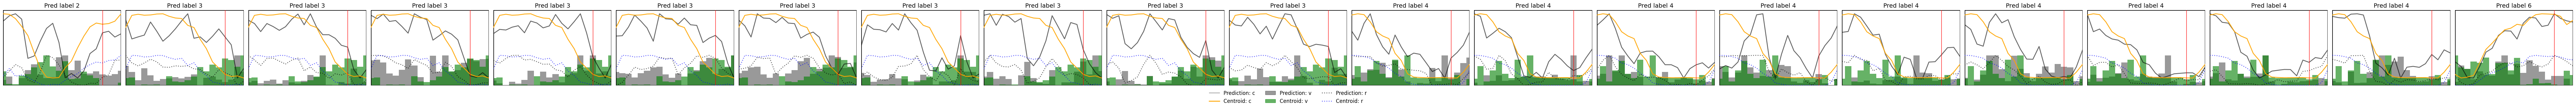

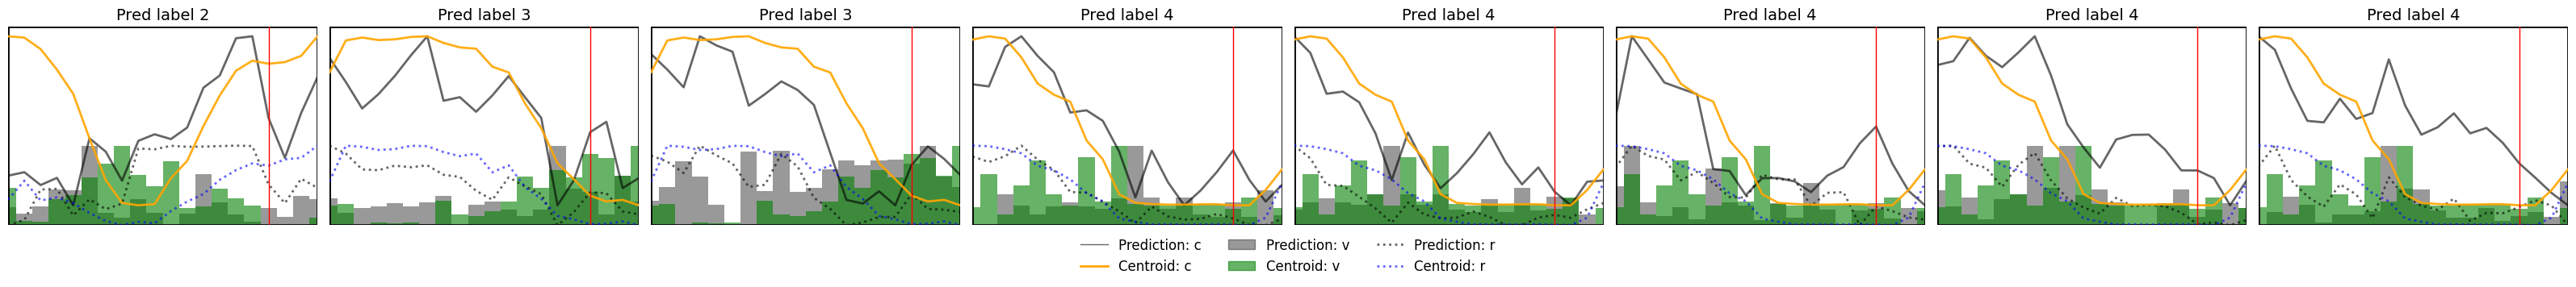

In [591]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def overlay_prediction_with_centroid(sequences, labels, centroids, variable):
    """
    예측 시퀀스와 centroid를 subplot에 그려서 비교.
    - centroid: 색상 포함된 실선, bar, 점선
    - sequence: 모두 검정색으로 c(실선), v(bar), r(점선)
    - subplot 비율 4:3, 검은 테두리, 양쪽 padding 제거
    """
    centroid_color_map = {'c': 'orange', 'v': 'green', 'r': 'blue'}
    range_map = {'c': (0.1, 0.95), 'v': (0, 0.4), 'r': (0.0, 0.4)}

    n_seqs = len(sequences)
    fig, axs = plt.subplots(1, n_seqs, figsize=(n_seqs * 4, 3))

    if n_seqs == 1:
        axs = [axs]

    for i in range(n_seqs):
        seq = sequences[i]            # (3, T_pred)
        label = labels[i]
        ax = axs[i]
        T_pred = seq.shape[1]
        x_axis = np.arange(T_pred)

        # 예측 시퀀스 (모두 검정색)
        for j in reversed(range(seq.shape[0])):
            s = seq[j]
            norm = (s - np.min(s)) / (np.max(s) - np.min(s) + 1e-6)
            low, high = range_map[variable[j]]
            scaled = norm * (high - low) + low

            if variable[j] == 'v':
                ax.bar(x_axis, scaled, color='black', width=1.0, alpha=0.4)
            elif variable[j] == 'r':
                ax.plot(x_axis, scaled, color='black', linestyle=':', linewidth=2.0, alpha=0.6)
            else:  # 'c'
                ax.plot(x_axis, scaled, color='black', linestyle='-', linewidth=2.0, alpha=0.6)

        # centroid 보간 후 실선/점선/bar
        center = centroids[label]     # (T_cent, 3)
        T_cent = center.shape[0]
        x_old = np.linspace(0, 1, T_cent)
        x_new = np.linspace(0, 1, T_pred)

        for j in reversed(range(center.shape[1])):
            series = center[:, j]
            interp_func = interp1d(x_old, series, kind='linear')
            interpolated = interp_func(x_new)

            norm = (interpolated - np.min(interpolated)) / (np.max(interpolated) - np.min(interpolated) + 1e-6)
            low, high = range_map[variable[j]]
            scaled = norm * (high - low) + low

            color = centroid_color_map[variable[j]]
            if variable[j] == 'v':
                ax.bar(x_axis, scaled, color=color, width=1.0, alpha=0.6)
            elif variable[j] == 'r':
                ax.plot(x_axis, scaled, color=color, linestyle=':', linewidth=2.0, alpha=0.6)
            else:  # 'c'
                ax.plot(x_axis, scaled, color=color, linestyle='-', linewidth=2.0, alpha=0.9)

        # 설정
        ax.set_title(f'Pred label {label}', fontsize=14)
        ax.axvline(x=16, color='red', linestyle='-', linewidth=1)
        ax.set_xlim(0, T_pred - 1)  # 📌 x축 padding 제거
        ax.set_ylim(0, 1)
        ax.axis('off')

        # 검은 테두리
        rect = patches.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            fill=False,
            edgecolor='black',
            linewidth=2
        )
        ax.add_patch(rect)

    # 📌 범례 (centroid / prediction)

    fig.legend(handles=[
        plt.Line2D([0],[0],color='black',alpha=0.6,linestyle='-',linewidth=1,label='Prediction: c'),
        plt.Line2D([0],[0],color='orange',linestyle='-',linewidth=2,label='Centroid: c'),
        plt.Rectangle((0,0),1,1,color='black',alpha=0.4,label='Prediction: v'),
        plt.Rectangle((0,0),1,1,color='green',alpha=0.6,label='Centroid: v'),
        plt.Line2D([0],[0],color='black',alpha=0.6,linestyle=':',linewidth=2,label='Prediction: r'),
        plt.Line2D([0],[0],color='blue',alpha=0.6,linestyle=':',linewidth=2,label='Centroid: r')],
        loc='lower center', ncol=3, frameon=False, fontsize=12, bbox_to_anchor=(0.5, -0.2)
    )



    plt.tight_layout()
    plt.show()



overlay_prediction_with_centroid(
    sequences=correct_seq_sorted,        # (N, 3, T_pred)
    labels=correct_label_sorted,         # (N,)
    centroids=new_centroid,              # (L, T_cent, 3)
    variable=['c', 'v', 'r']
)

overlay_prediction_with_centroid(
    sequences=incorrect_seq_sorted,        # (N, 3, T_pred)
    labels=incorrect_label_sorted,         # (N,)
    centroids=new_centroid,              # (L, T_cent, 3)
    variable=['c', 'v', 'r']
)
